In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torch.nn as nn
import torch.optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Normalize, RandomHorizontalFlip, Resize, ColorJitter
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

torch.cuda.empty_cache()
device=torch.device("cuda" if torch.cuda.is_available else "cpu")

C:\Users\daisu\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\daisu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\daisu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


Check current directory

In [2]:
pwd

'C:\\Users\\daisu\\OneDrive\\Desktop\\Kaggle'

Unzip archive zip file to the specified directory using %%bash command

In [22]:
# %%bash

# unzip "archive.zip" -d "GTSRB"

Archive:  archive.zip
  inflating: GTSRB/Meta.csv          
  inflating: GTSRB/Meta/.~lock.ClassesInformation.ods#  
  inflating: GTSRB/Meta/.~lock.ClassesInformationStrong.ods#  
  inflating: GTSRB/Meta/0.png        
  inflating: GTSRB/Meta/1.png        
  inflating: GTSRB/Meta/10.png       
  inflating: GTSRB/Meta/11.png       
  inflating: GTSRB/Meta/12.png       
  inflating: GTSRB/Meta/13.png       
  inflating: GTSRB/Meta/14.png       
  inflating: GTSRB/Meta/15.png       
  inflating: GTSRB/Meta/16.png       
  inflating: GTSRB/Meta/17.png       
  inflating: GTSRB/Meta/18.png       
  inflating: GTSRB/Meta/19.png       
  inflating: GTSRB/Meta/2.png        
  inflating: GTSRB/Meta/20.png       
  inflating: GTSRB/Meta/21.png       
  inflating: GTSRB/Meta/22.png       
  inflating: GTSRB/Meta/23.png       
  inflating: GTSRB/Meta/24.png       
  inflating: GTSRB/Meta/25.png       
  inflating: GTSRB/Meta/26.png       
  inflating: GTSRB/Meta/27.png       
  inflating: GTSRB/Met

replace GTSRB/meta/.~lock.ClassesInformation.ods#? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


CalledProcessError: Command 'b'\nunzip "archive.zip" -d "GTSRB"\n'' returned non-zero exit status 1.

In [2]:
train_dir = "GTSRB/train"
test_dir = "GTSRB/test"

In [33]:
train_file = [os.path.join(train_dir, f) for f in os.listdir(train_dir)]
test_file = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

Get labels, cast to integer, sort values, then recast to string

In [3]:
labels=os.listdir(train_dir)
labels = list(map(int, labels))
labels.sort()
labels = list(map(str, labels))

In [4]:
class_name = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [5]:
transform=torchvision.transforms.Compose([
    Resize((150, 150)),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(0.3, 0.4, 0.4, 0.2),
    ToTensor(),
    Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
])

train_set = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_set = torchvision.datasets.ImageFolder(test_dir, transform=transform)

# trainloader=DataLoader(train_set, batch_size=5, shuffle=True)
# testloader=DataLoader(test_set, batch_size=20, shuffle=False)

class_names= train_set.classes


In [6]:
valid_size = 0.2
# Splot data into train and validation set
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [15]:
# CPU core numbers
import os
os.cpu_count()  # Core numbers

16

In [16]:
train_loader = DataLoader(train_set,batch_size=5,sampler=train_sampler,num_workers=4)
valid_loader = DataLoader(train_set, batch_size =20, sampler=valid_sampler, num_workers=3)
test_loader= DataLoader(test_set,batch_size=20,shuffle=False,num_workers=4)

Output class: tensor([18, 12, 42, 34,  9])
Original class: [[25], [2], [9], [4], [17]]


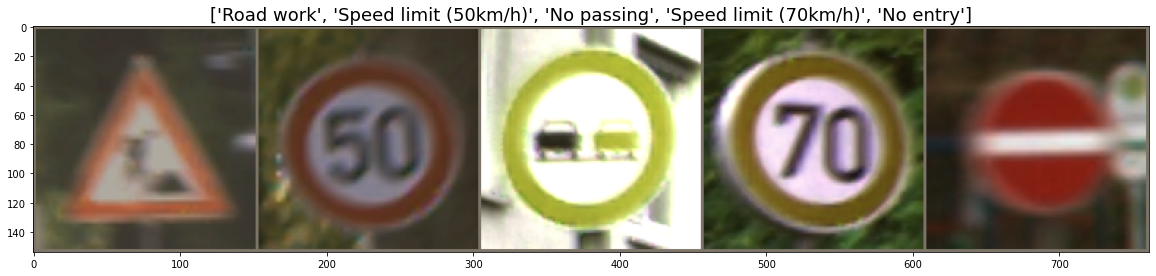

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=18)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get the first batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# As train_loader return the index as its class, 
# We need to use the original order of class
print(f"Output class: {classes}")
print(f"Original class: {[[int(class_names[x])] for x in classes]}")
imshow(out, title=[class_name[int(class_names[x])] for x in classes])

In [18]:
model = torchvision.models.wide_resnet50_2(pretrained=True)

In [37]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [38]:
for param in model.parameters():
    param.required_grad=True
    
n_feature = model.fc.in_features
model.fc=nn.Linear(n_feature, len(labels))
model.to(device)

RuntimeError: CUDA error: device-side assert triggered

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=0.01)
scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6], gamma=0.06)

epochs=5
# track change in validation loss
valid_loss_min = np.Inf
val_loss = []
tn_loss = []


for epoch in range(epochs):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Train the model
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # clear the gradiant of all optimizer variable
        optimizer.zero_grad()
        # forward pass: compute pradictions by passing inputs
        output = model(data)
        # calculate batch loss
        loss = criterion(output, target)
        # backward pass: compute gradiant of the loss with respect to the parameters
        loss.backward()
        # update parameters by optimizing single step
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)  

    # validate the model

    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensor to gpu
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # forward pass: compute the validation predictions
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update the validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average loss
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    val_loss.append(valid_loss)
    tn_loss.append(train_loss)
    # update learning rate
    scheduler.step()
    # Print the train and validation loss statistic
    print('Epoch: {} \t Training Loss: {:.3f} \t Validation Loss: {:.3f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss decrease
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased {:.4f}--->{:.4f}  Saving model...".format(valid_loss_min, valid_loss))
        # save current model
        torch.save(model.state_dict(), 'model_state.pt')
        valid_loss_min = valid_loss
    print('Learning Rate ------------->{:.4f}'.format(optimizer.state_dict()['param_groups'][0]['lr']))        

RuntimeError: CUDA error: device-side assert triggered

Show the model evaluation

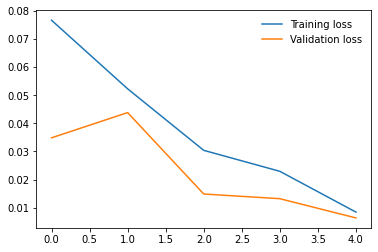

In [26]:
plt.plot(tn_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(frameon=False)


plt.show()

Load saved parameters

In [27]:
# Load model state dict
model.load_state_dict(torch.load('model_state.pt'))
model.eval()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

## Predictions on test dataset

In [28]:
correct_count, all_count = 0,0
for images, labels in test_loader:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        img = images[i].view(1,3,150,150)
        with torch.no_grad():
            logps = model(img)
            
        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1
        
print("Number of images Tested=", all_count)
print("\n Model Accuracy=",(correct_count/all_count)*100)

Number of images Tested= 12630

 Model Accuracy= 0.4750593824228029


## Image Predictions

In [29]:
def pred_class(img):
    # transform images
    img_tens = transform_tests(img)
    # change image format (3,150,150) to (1,3,150,150) by help of unsqueeze function
    # image needs to be in cuda before predition
    img_im = img_tens.unsqueeze(0).cuda() 
    uinput = Variable(img_im)
    uinput = uinput.to(device)
    out = model(uinput)
    # convert image to numpy format in cpu and snatching max prediction score class index
    index = out.data.cpu().numpy().argmax()    
    return index

In [34]:
# make class dictionary so i can grab class name by index(key)
classes = {k:v for k , v in enumerate(sorted(labels))}
model.eval()


plt.figure(figsize=(20,20))
for i, images in enumerate(test_file):
    # just want 25 images to print
    if i > 24:break
    img = Image.open(images)
    index = pred_class(img)
    plt.subplot(5,5,i+1)
    plt.title(classes[index])
    plt.axis('off')
    plt.imshow(img)

PermissionError: [Errno 13] Permission denied: 'GTSRB/test\\Test1'

<Figure size 1440x1440 with 0 Axes>